<h1 style="text-align: center;">Brain Tumor MRI Classification using Deep Learning</h1>
<h2 style="text-align: center;">Comparative Study of CNN Architectures for Brain Tumor MRI Classification</h2>
<h3 style="text-align: center;">Simon VELLIN    |   Aleksandr SMOLIN    |  Nicholas RAUTH</h3>

This notebook implements several CNN-based approach to classify brain MRI images into 4 categories:
- **Glioma**$\to$ A type of brain tumor
- **Meningioma**$\to$ Another type of brain tumor
- **No Tumor**$\to$ Healthy brain scans
- **Pituitary**$\to$ Pituitary gland tumors

## Imports & Configuration

Libraries:

In [1]:
# Standard Python libraries
import json
import os
import random
from collections import Counter
from pathlib import Path

# Data science libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications import EfficientNetB0, VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.metrics import Precision, Recall, TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Kaggle
import kagglehub

2025-06-17 21:04:50.041289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750194290.241706      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750194290.301704      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Optional Setup for Apple Silicon Devices:

 TensorFlow will automatically pick the best device it finds (GPU via MPS or CPU) by default. But you can run this to confirm you’re actually running on the GPU (or CPU) and set TensorFlow’s memory-growth mode, which can prevent OOM crashes on M1/M2 machines.

In [2]:
print("Brain Tumor MRI Classification System")
print("Configuring device for Apple Silicon...")

if tf.config.list_physical_devices('GPU'):
    print("✅ MPS (Metal Performance Shaders) available")
    try:
        tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
        print("✅ GPU memory growth enabled")
    except:
        print("⚠️ GPU memory growth could not be enabled")
    device = "/GPU:0"  
    print("✅ Using Apple Silicon GPU (MPS)")
else:
    print("⚠️ GPU not available, using CPU")
    device = "/CPU:0"

print(f"TensorFlow version: {tf.__version__}")
print(f"Using device: {device}")

print("\nAvailable devices:")
for device_info in tf.config.list_physical_devices():
    print(f"  {device_info}")

Brain Tumor MRI Classification System
Configuring device for Apple Silicon...
✅ MPS (Metal Performance Shaders) available
✅ GPU memory growth enabled
✅ Using Apple Silicon GPU (MPS)
TensorFlow version: 2.18.0
Using device: /GPU:0

Available devices:
  PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. DATA LOADING

In case you have the dataset already downloaded locally, place it in the repo's parent directory and rename it "data". Else, the cell will download the data from Kaggle.

In [3]:
# IF LOCAL: locate data folder
project_root = Path().resolve().parent   
local_data   = project_root / "data"

if local_data.exists():
    print(f"✅ Using local data folder at {local_data}")
    base_path = local_data
else:
    # ELSE: download via kagglehub
    try:
        import kagglehub
        print("Local data not found, downloading via kagglehub…")
        base_path = Path(kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset"))
        print(f"✅ Download complete: {base_path}")
    except ImportError:
        raise RuntimeError(
            "❌ Could not find local data and kagglehub is not installed.\n"
            "Please either place your data in a `data/` folder or `pip install kagglehub`."
        )

# Define train & test paths
TRAIN_DATASET_PATH = base_path / "Training"
TEST_DATASET_PATH  = base_path / "Testing"

# Sanity check
assert TRAIN_DATASET_PATH.exists(), f"Training folder missing at {TRAIN_DATASET_PATH}"
assert TEST_DATASET_PATH.exists(),  f"Testing folder missing at {TEST_DATASET_PATH}"

print(f"Training data path: {TRAIN_DATASET_PATH}")
print(f"Testing  data path: {TEST_DATASET_PATH}")

Local data not found, downloading via kagglehub…
✅ Download complete: /kaggle/input/brain-tumor-mri-dataset
Training data path: /kaggle/input/brain-tumor-mri-dataset/Training
Testing  data path: /kaggle/input/brain-tumor-mri-dataset/Testing


Ensure the below cells correctly detects for the four classes:

In [4]:
classes = sorted([d for d in os.listdir(TRAIN_DATASET_PATH) if os.path.isdir(os.path.join(TRAIN_DATASET_PATH, d))])
num_classes = len(classes)
print(f"Detected classes: {classes}")

Detected classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


# 2. DATA EXPLORATION

## a) Class Imbalance

In [5]:
# Count images per class
def count_images(folder):
    return {cls: len(os.listdir(os.path.join(folder, cls))) for cls in classes}

train_counts = count_images(TRAIN_DATASET_PATH)
test_counts  = count_images(TEST_DATASET_PATH)

print("Training counts:", train_counts)
print("Testing counts: ", test_counts)

Training counts: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Testing counts:  {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


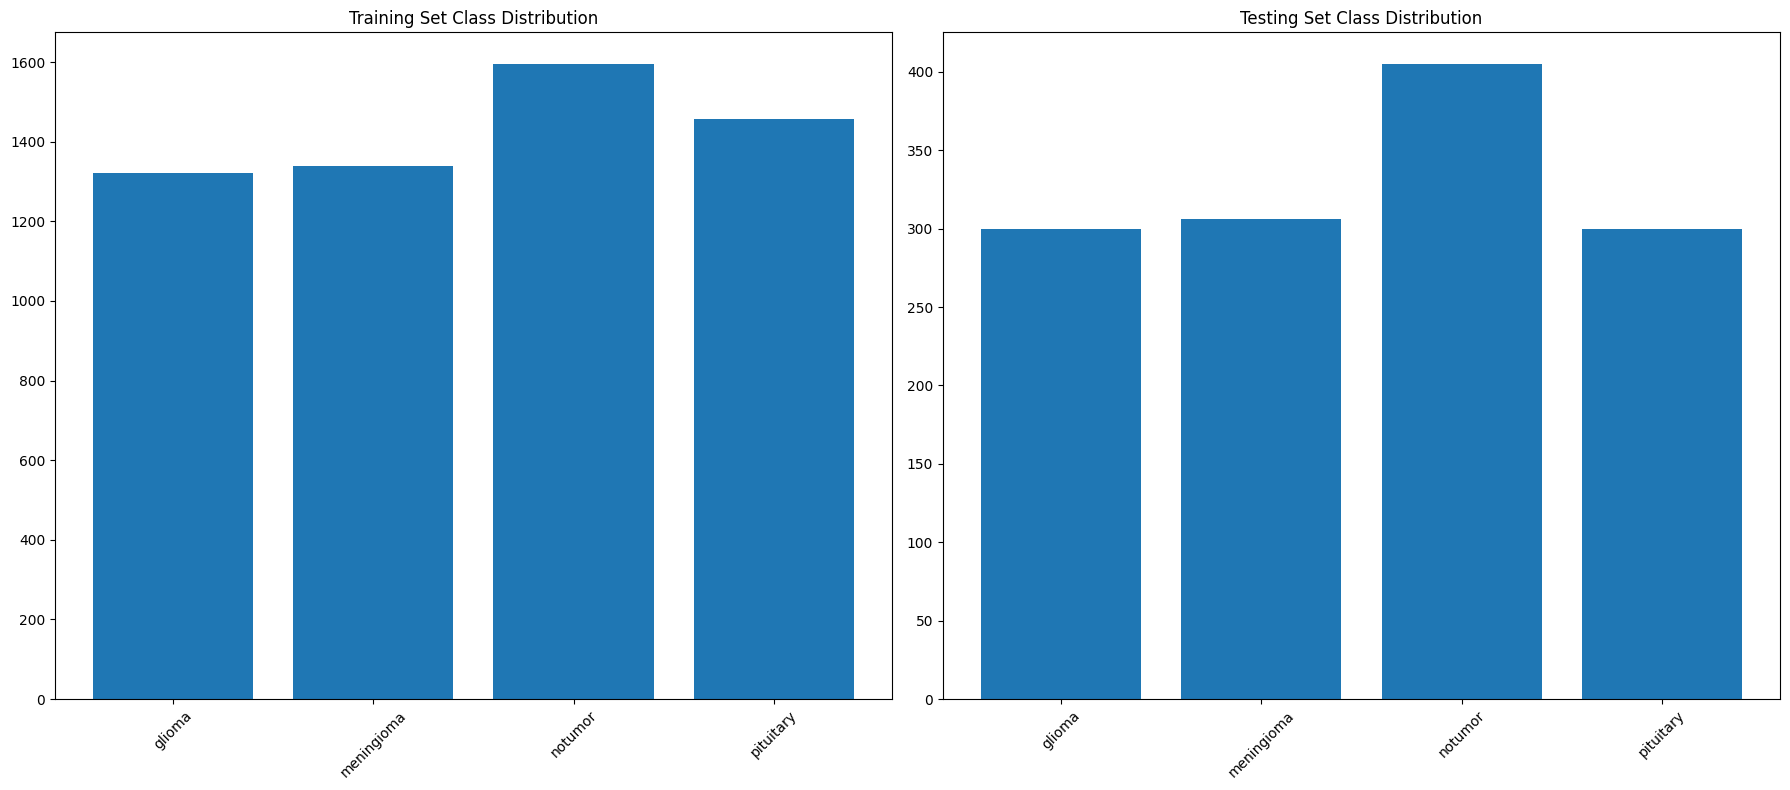

In [6]:
# Plot
plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.bar(train_counts.keys(), train_counts.values())
plt.title('Training Set Class Distribution')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.bar(test_counts.keys(), test_counts.values())
plt.title('Testing Set Class Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## b) Visualize Sample

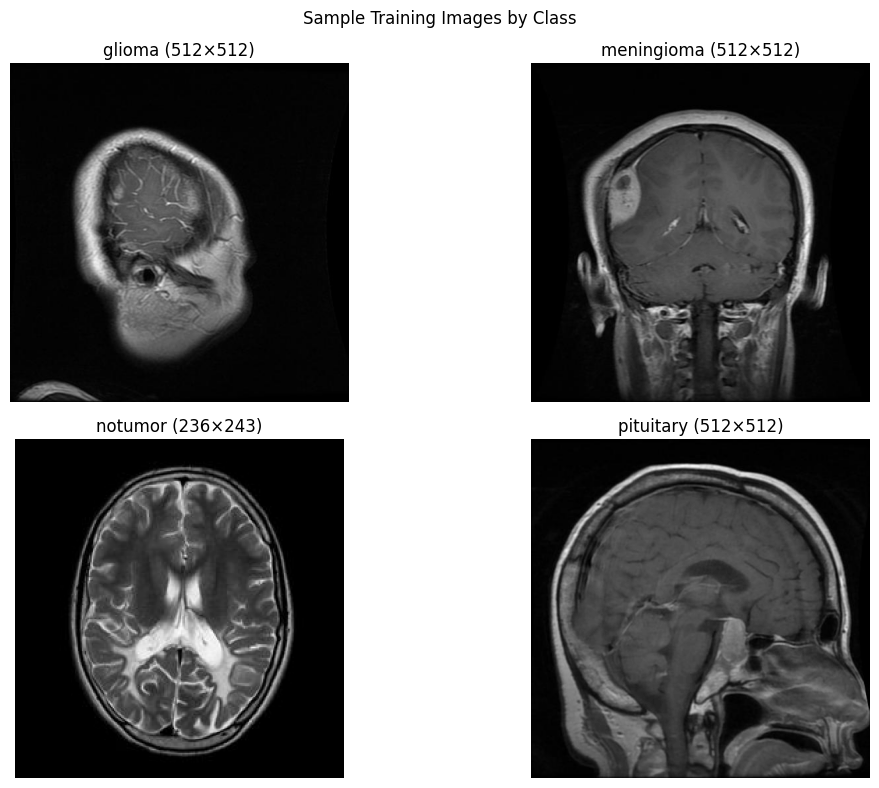

In [7]:
# Display one random sample per class (from training set)
plt.figure(figsize=(12,8))
for i, cls in enumerate(classes):
    ax = plt.subplot(2, 2, i+1)
    img_name = random.choice(os.listdir(os.path.join(TRAIN_DATASET_PATH, cls)))
    img_path = os.path.join(TRAIN_DATASET_PATH, cls, img_name)
    img = Image.open(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{cls} ({img.size[0]}×{img.size[1]})")
    ax.axis('off')

plt.suptitle('Sample Training Images by Class')
plt.tight_layout()
plt.show()

## c) Resolution Imbalance

`We notice that there might be differences in image sizes, which might be a problem for model performance later on, so we plot the most used image resolution in training set:`

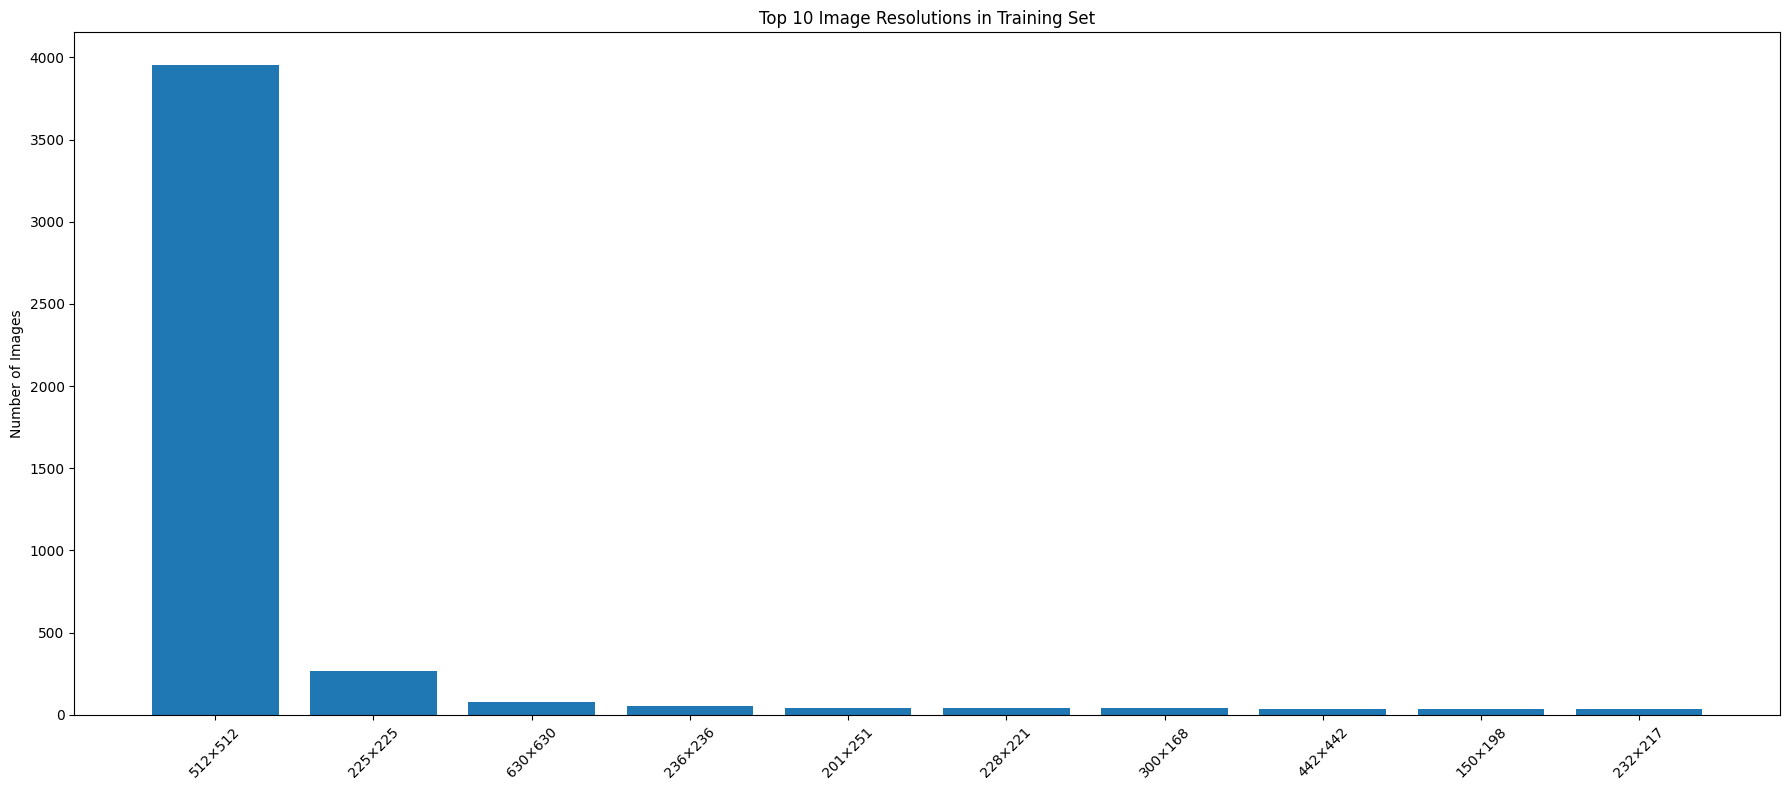

In [8]:
# Gather and count all training-image resolutions
size_counts = Counter()
for cls in classes:
    cls_dir = os.path.join(TRAIN_DATASET_PATH, cls)
    for fname in os.listdir(cls_dir):
        w, h = Image.open(os.path.join(cls_dir, fname)).size
        size_counts[(w, h)] += 1

# Plot the top-10 most common 
common = size_counts.most_common(10)
labels  = [f"{w}×{h}" for (w, h), _ in common]
counts  = [cnt for _, cnt in common]

plt.figure(figsize=(18, 8))
plt.bar(labels, counts)
plt.title("Top 10 Image Resolutions in Training Set")
plt.xticks(rotation=45)
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

`Indeed, although the size 512x512 is largely dominating, we have still too much variation, so we decide to resize all images to a fixed size`.

# 3. DATA WRANGLING

## a) Test Resizing

We start by previewing the resizing of one image to see if this technique maintains the core input needed (i.e. brain) at the center of the image to train our model.

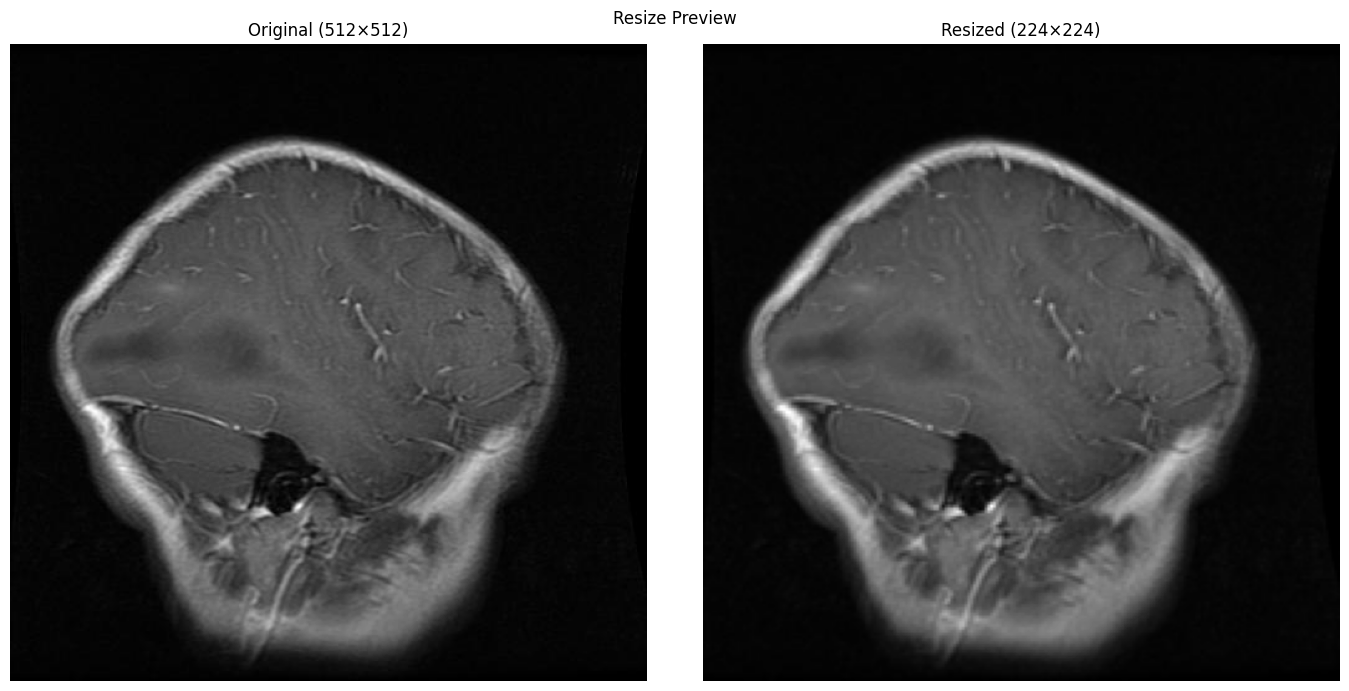

In [9]:
TARGET_SIZE = (224, 224)
sample_cls   = classes[0]
sample_file  = random.choice(os.listdir(os.path.join(TRAIN_DATASET_PATH, sample_cls)))
orig_img     = Image.open(os.path.join(TRAIN_DATASET_PATH, sample_cls, sample_file))
resized_img  = orig_img.resize(TARGET_SIZE)

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(orig_img, cmap='gray')
plt.title(f"Original ({orig_img.size[0]}×{orig_img.size[1]})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(resized_img, cmap='gray')
plt.title(f"Resized ({TARGET_SIZE[0]}×{TARGET_SIZE[1]})")
plt.axis('off')

plt.suptitle("Resize Preview")
plt.tight_layout()
plt.show()

## b) Resizing Loop

We start by defining the parameters of our resizing loop, and justify their respective value below:

In [10]:
BATCH_SIZE  = 32
IMG_SIZE    = (224, 224)    
SEED        = 42

`Why BATCH = 32?`

Although it does not change the fundamental algorithm, small batch consume less GPU memory, thus reducing the risk of out-of-memory errors. In addition, (32, 64, 128) tend to map more efficiently onto GPU memory allocators and tensor cores.

`Why SIZE = 224×224?`

Most widely adopted backbones (ResNet, VGG, EfficientNet, MobileNet, etc.) are pre‐trained on ImageNet images resized to **224×224**. By matching this input size:

1. **Leverage Transfer Learning**  
   - Import pre‐trained weights without architectural changes.  
   - Benefit from general “edge” and “texture” features learned on millions of images.

2. **Ensure Architectural Consistency**  
   - Convolutional blocks, pooling layers, and fully‐connected heads are tuned for 224×224.  
   - Preserves expected feature map dimensions, avoiding manual re‐engineering of strides or global pooling.

3. **Maintain Efficient Computation**  
   - Balances detail retention (sufficient resolution for tumor boundaries) with GPU memory limits.  
   - Smaller than full MRI resolution, but large enough to capture critical anatomy.

`Why SEED = 42?`

- **Reproducibility:** Ensures identical train/val/test splits, shuffles, and augmentations across runs.  
- **Fair Comparison:** Eliminates randomness when benchmarking different models.  
- **Standard Convention:** “42” is a common arbitrary choice for consistency.  

In [11]:
# Load datasets with a fixed split
train_ds = image_dataset_from_directory(
    TRAIN_DATASET_PATH,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_ds = image_dataset_from_directory(
    TRAIN_DATASET_PATH,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_ds = image_dataset_from_directory(
    TEST_DATASET_PATH,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


I0000 00:00:1750194342.775414      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


## c) Normalization & Augmentation

We now aim for a unified pipeline with MRI-specific normalization & augmentation. It benefits:

- **Consistency Across Models:**  
  A single `tf.data` workflow ensures every architecture sees identical data splits, resizing, normalization, and augmentations.  

- **Reproducibility:**  
  Fixed `SEED` in loading and each augmentation layer guarantees the same shuffles and transformations, enabling fair, repeatable comparisons.  

- **Medical-Grade Augmentation:**  
  Conservative random flips, rotations (±10°), small translations (±5%) and zooms (±5%) mimic realistic MRI variations without distorting pathology.  

- **Performance & Scalability:**  
  On-the-fly batching, mapping, and prefetching leverage `AUTOTUNE` for GPU-efficient data throughput, crucial when benchmarking multiple backbones.

In [12]:
preprocess_layer = layers.Rescaling(1./255)

augmenter = tf.keras.Sequential([
    layers.RandomFlip('horizontal', seed=SEED),
    layers.RandomRotation(0.1,   seed=SEED),
    layers.RandomTranslation(0.05, 0.05, seed=SEED),
    layers.RandomZoom(0.05,      seed=SEED),
])

def preprocess(image, label, augment=False):
    image = preprocess_layer(image)
    if augment:
        image = augmenter(image)
    return image, label

# 3.4 Apply to datasets & prefetch
train_ds = train_ds.map(lambda x, y: preprocess(x, y, augment=True)) \
                   .prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: preprocess(x, y, augment=False)) \
                 .prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: preprocess(x, y, augment=False)) \
                 .prefetch(tf.data.AUTOTUNE)

print(" Unified data pipeline ready")

 Unified data pipeline ready


## d) Visualizing

`We do not apply augmentation to validation and test data` since we want to increase the variability in the training only. Verifying consistency:

In [13]:
for img, _ in train_ds.take(1):
    print("Train shape:", img.shape, "Min/Max:", img.numpy().min(), img.numpy().max())
for img, _ in val_ds.take(1):
    print("Val shape:", img.shape, "Min/Max:", img.numpy().min(), img.numpy().max())

Train shape: (32, 224, 224, 3) Min/Max: 0.0 0.99681664
Val shape: (32, 224, 224, 3) Min/Max: 0.0 1.0


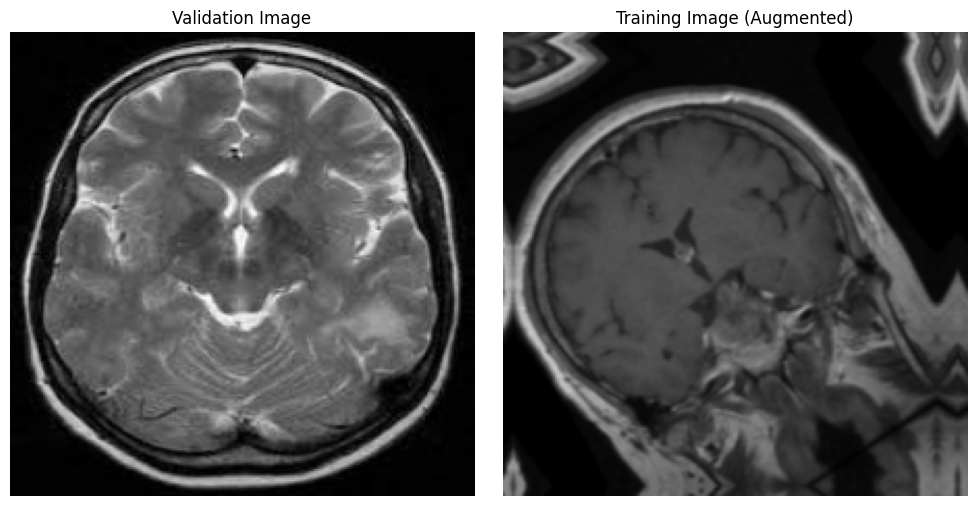

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
for img, lbl in val_ds.take(1):
    ax1.imshow(img[0].numpy())
    ax1.set_title("Validation Image")
    ax1.axis('off')
for img, lbl in train_ds.take(1):
    ax2.imshow(img[0].numpy())
    ax2.set_title("Training Image (Augmented)")
    ax2.axis('off')
plt.tight_layout()
plt.show()

`Shapes and ranges match, confirming consistent preprocessing (no augmentation on validation)`

This setup lays a rigorous foundation for our comparative study of CNN architectures, ensuring that any performance gains stem from model design—not data inconsistencies.

# 4. MODEL 1 - Baseline CNN (Epoch = 20 | LR = 1e-3)

This vanilla CNN serves as a strong from-scratch baseline before moving on to transfer learning. We stack **five Conv–BatchNorm–Pool blocks** with increasing filters (32→64→128→256→512) to capture progressively higher-level MRI features. A **Dense(256) + Dropout(0.5)** head provides enough capacity for classification while guarding against overfitting. We also apply **class-weighted training** to counter dataset imbalance, ensuring no single class dominates the loss.

`Key choices made:`

- **ReLU activation**  
  - Fast, non-saturating nonlinearity that helps avoid vanishing gradients.

- **Batch Normalization**  
  - Normalizes each layer’s inputs, accelerating convergence and reducing sensitivity to initialization.

- **padding='same'**  
  - Keeps feature maps the same size, simplifying network depth and preserving spatial context.

- **Softmax output**  
  - Produces a valid probability distribution over the four tumor classes.

- **Categorical cross-entropy loss**  
  - The standard multi-class objective, encouraging the network to align predicted probabilities with true one-hot labels.

## a) Implementation

In [15]:
# Model Definition
model = Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(512, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile with Accuracy + Precision + Recall
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

model.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('advanced_vanilla.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Compute class weights
labels_list = []
for _, y in train_ds:
    labels_list.extend(tf.argmax(y, axis=1).numpy())
class_weights = compute_class_weight('balanced', classes=np.arange(num_classes), y=labels_list)
class_weight_dict = dict(enumerate(class_weights))

# Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=2
)

# Evaluate on Test Set
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds, verbose=2)
print(f"\nTest — Acc: {test_acc:.4f}, Prec: {test_prec:.4f}, Rec: {test_rec:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 14, 14, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │              

 Total params: 7,996,356 (30.50 MB)

 Trainable params: 7,994,372 (30.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/20


I0000 00:00:1750194422.087611      68 service.cc:148] XLA service 0x7e7f2c002360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750194422.089135      68 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750194422.758473      68 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750194429.423396      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_accuracy improved from -inf to 0.26357, saving model to advanced_vanilla.h5
143/143 - 86s - 602ms/step - accuracy: 0.5201 - loss: 2.6532 - precision: 0.6295 - recall: 0.3685 - val_accuracy: 0.2636 - val_loss: 7.2283 - val_precision: 0.2636 - val_recall: 0.2636 - learning_rate: 0.0010
Epoch 2/20

Epoch 2: val_accuracy did not improve from 0.26357
143/143 - 65s - 456ms/step - accuracy: 0.5761 - loss: 1.0108 - precision: 0.7119 - recall: 0.4033 - val_accuracy: 0.2636 - val_loss: 8.8012 - val_precision: 0.2636 - val_recall: 0.2636 - learning_rate: 0.0010
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.26357
143/143 - 65s - 458ms/step - accuracy: 0.6438 - loss: 0.9103 - precision: 0.7559 - recall: 0.5042 - val_accuracy: 0.2180 - val_loss: 9.7266 - val_precision: 0.2180 - val_recall: 0.2180 - learning_rate: 0.0010
Epoch 4/20

Epoch 4: val_accuracy improved from 0.26357 to 0.31436, saving model to advanced_vanilla.h5
143/143 - 66s - 464ms/step - accuracy: 0.6720 - loss:

## b) Training Plots

The below cell is a `generic training & validation metrics per epoch plot` which will be used after each model to have a standardized 2×2 view in case the four metrics (Accuracy, Loss, Precision, Recall) were computed, else it simply skip the metric.

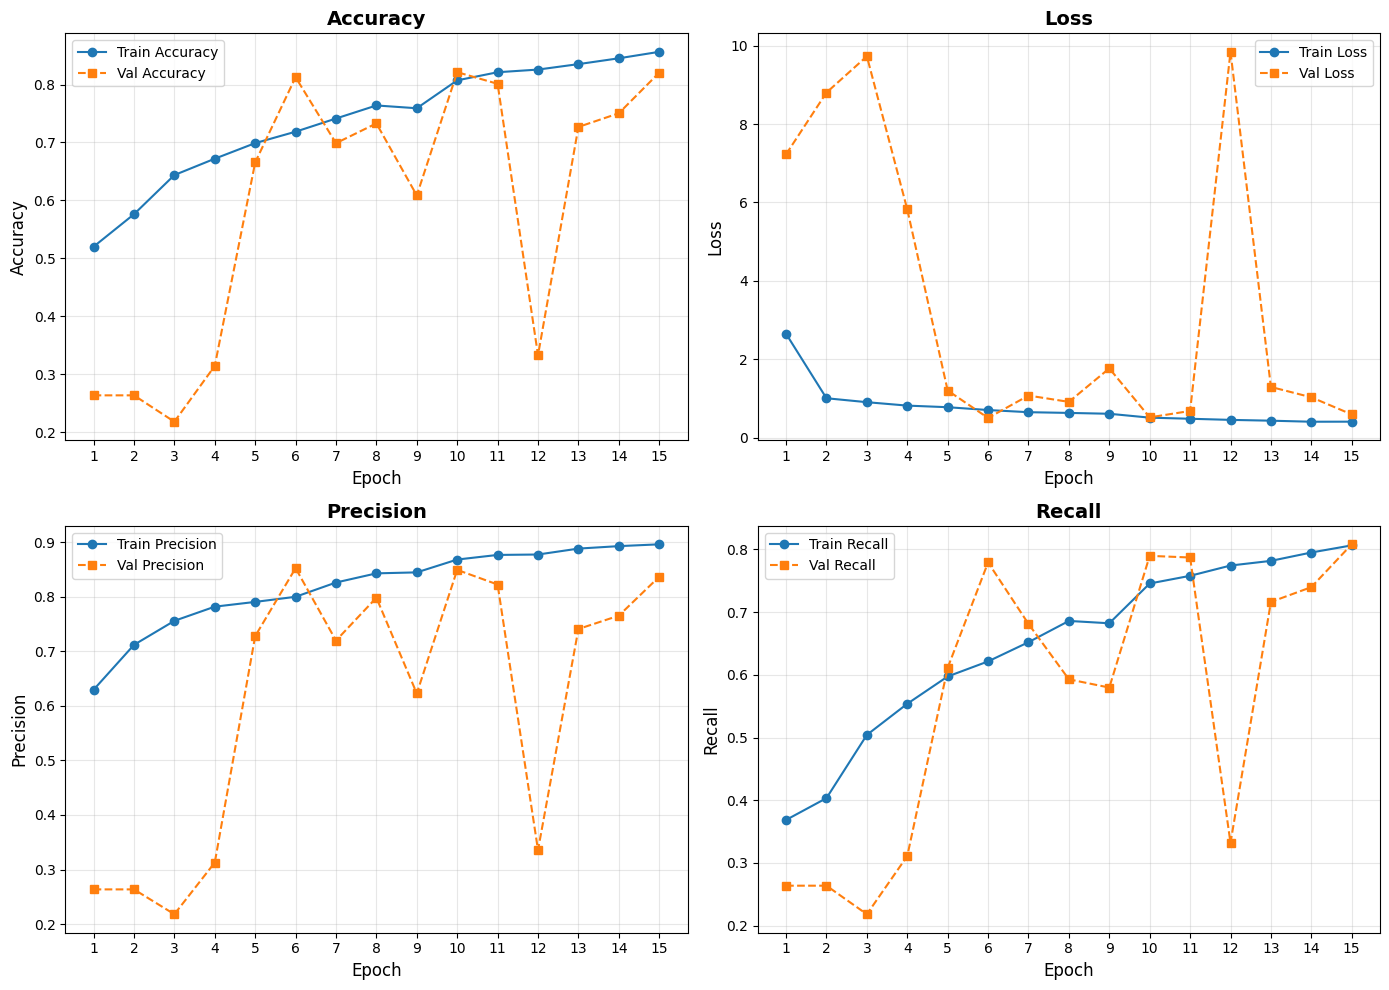

In [16]:
# metrics to plot
metrics = {
    'Accuracy':    ('accuracy', 'val_accuracy'),
    'Loss':        ('loss',     'val_loss'),
    'Precision':   ('precision','val_precision'),
    'Recall':      ('recall',   'val_recall'),
}

epochs = range(1, len(history.history['accuracy']) + 1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = {
    'train': 'tab:blue',
    'val':   'tab:orange'
}
styles = {
    'train': '-',
    'val':   '--'
}

for ax, (title, (train_key, val_key)) in zip(axes, metrics.items()):
    # skip if metric not in history
    if train_key not in history.history:
        ax.set_visible(False)
        continue

    ax.plot(epochs, history.history[train_key], color=colors['train'],
            linestyle=styles['train'], marker='o', label=f'Train {title}')
    ax.plot(epochs, history.history[val_key], color=colors['val'],
            linestyle=styles['val'], marker='s', label=f'Val {title}')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    ax.set_xticks(epochs)

plt.tight_layout()
plt.show()

## c) Results & Comment

Classification Report:

              precision    recall  f1-score   support

      glioma       0.83      0.85      0.84       300
  meningioma       0.71      0.45      0.55       306
     notumor       0.77      0.97      0.86       405
   pituitary       0.89      0.86      0.87       300

    accuracy                           0.80      1311
   macro avg       0.80      0.79      0.78      1311
weighted avg       0.79      0.80      0.79      1311



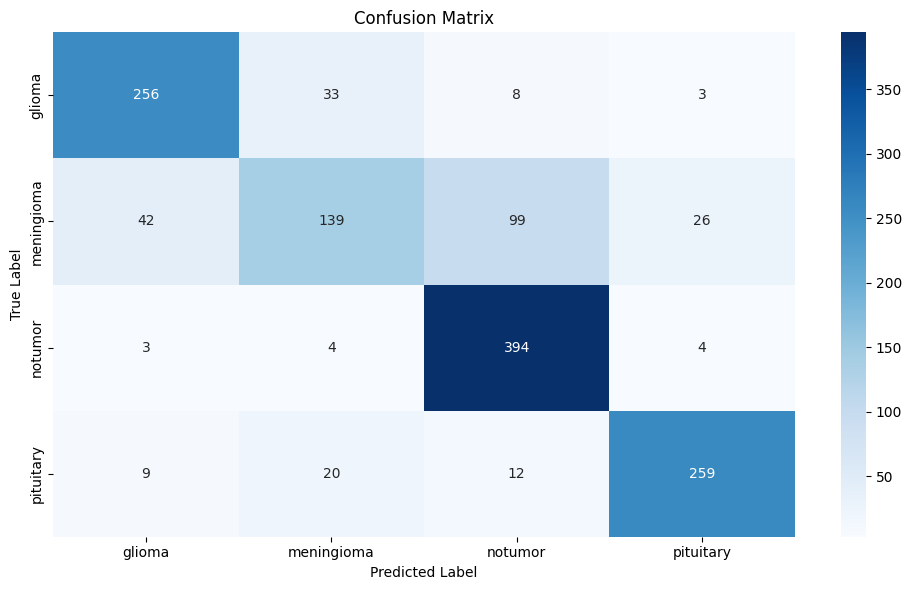

In [17]:
# Collect ground-truth and predictions
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

y_probs = model.predict(test_ds, verbose=0)
y_pred  = np.argmax(y_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print detailed report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

`Model 1 – Baseline CNN`  
- **Test accuracy:** 80%
- **Strength:** Virtually perfect “No Tumor” detection (394/405).  
- **Weaknesses:**  
  - **Glioma ↔ Meningioma confusion** (33 glioma→meningioma; 42 meningioma→glioma).  
  - **Meningioma ↔ No Tumor overlap** (99 meningioma→no-tumor).  

From-scratch filters capture broad pathology vs. healthy tissue but lack the nuanced texture discrimination needed for reliable tumor subtyping.

## d) Export

In [18]:
# Training history → JSON
hist_cnn_path = Path("history_cnn.json")
with open(hist_cnn_path, "w") as f:
    json.dump(history.history, f, indent=2)

# Confusion matrix → .npy
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)
y_probs = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_probs, axis=1)
cm = confusion_matrix(y_true, y_pred)
cm_cnn_path = Path("cm_cnn.npy")
np.save(cm_cnn_path, cm)

# Classification report → TXT
report_cnn = classification_report(y_true, y_pred, target_names=classes)
report_cnn_path = Path("report_cnn.txt")
with open(report_cnn_path, "w") as f:
    f.write(report_cnn)

print(f"✅ Saved Baseline CNN history → {hist_cnn_path}")
print(f"✅ Saved Baseline CNN confusion matrix → {cm_cnn_path}")
print(f"✅ Saved Baseline CNN report → {report_cnn_path}")

✅ Saved Baseline CNN history → history_cnn.json
✅ Saved Baseline CNN confusion matrix → cm_cnn.npy
✅ Saved Baseline CNN report → report_cnn.txt


# 5. MODEL 2 - VGG19 Transfer Learning (Epoch = 30 | LR = 1e-4)

This second model leverages **VGG19 transfer learning** to jumpstart feature extraction from millions of ImageNet images. By freezing the convolutional base, we reuse its rich edge, texture, and shape detectors, then add a lightweight classifier head (GlobalAvgPool→Dense(256)→Dropout→Softmax). Training only the top layers at a low LR (1e-4) lets us adapt high-level filters to MRI-specific patterns without overfitting.

`Key choices made:`

- **Preprocessing with `vgg19.preprocess_input`**  
  - Applies the exact mean-subtraction and scaling VGG19 expects, ensuring compatibility with its learned filters.  
- **Frozen convolutional base**  
  - Retains robust low- and mid-level feature maps, reducing training time and data requirements.  
- **GlobalAveragePooling2D**  
  - Pools feature maps to a fixed-size vector without adding extra parameters or flattening noise.  
- **Dense(256)+Dropout(0.5)**  
  - Provides enough capacity to remap ImageNet features to tumor classes while guarding against overfitting.  
- **Categorical cross-entropy + precision/recall metrics**  
  - Tracks both overall performance and per-class sensitivity/PPV critical in medical diagnostics.  

## a) Implementation

In [19]:
# Preprocess needed for VGG19
def preprocess_vgg(x, y):
    x = x * 255.0
    return tf.keras.applications.vgg19.preprocess_input(x), y

train_vgg = train_ds.map(preprocess_vgg).prefetch(tf.data.AUTOTUNE)
val_vgg   = val_ds.map(preprocess_vgg).prefetch(tf.data.AUTOTUNE)
test_vgg  = test_ds.map(preprocess_vgg).prefetch(tf.data.AUTOTUNE)

# Model definition
base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False

model_vgg = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model_vgg.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

model_vgg.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint('vgg19_transfer.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

history_vgg = model_vgg.fit(
    train_vgg,
    validation_data=val_vgg,
    epochs=30,
    callbacks=callbacks,
    verbose=2
)

# Evaluate on Test Set
test_loss, test_acc, test_prec, test_rec = model_vgg.evaluate(test_vgg, verbose=2)
print(f"\nVGG19 Transfer — Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}")

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,156,740 (76.89 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.73555, saving model to vgg19_transfer.h5
143/143 - 92s - 645ms/step - accuracy: 0.4991 - loss: 1.7580 - precision: 0.5179 - recall: 0.4709 - val_accuracy: 0.7356 - val_loss: 0.7165 - val_precision: 0.7633 - val_recall: 0.6918 - learning_rate: 1.0000e-04
Epoch 2/30

Epoch 2: val_accuracy improved from 0.73555 to 0.79422, saving model to vgg19_transfer.h5
143/143 - 71s - 494ms/step - accuracy: 0.6742 - loss: 0.8894 - precision: 0.7029 - recall: 0.6446 - val_accuracy: 0.7942 - val_loss: 0.5775 - val_precision: 0.8199 - val_recall: 0.7653 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_accuracy improved from 0.79422 to 0.81699, saving model to vgg19_transfer.h5
143/143 - 70s - 490ms/step - accuracy: 0.7455 - loss: 0.6652 - precision: 0.7729 - recall: 0.7114 - val_accuracy: 0.8170 - val_loss: 0.5283 - val_precision: 0.8367 - val_recall: 0.7942 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_accuracy improved from 0.81699 to

## b) Training Plots

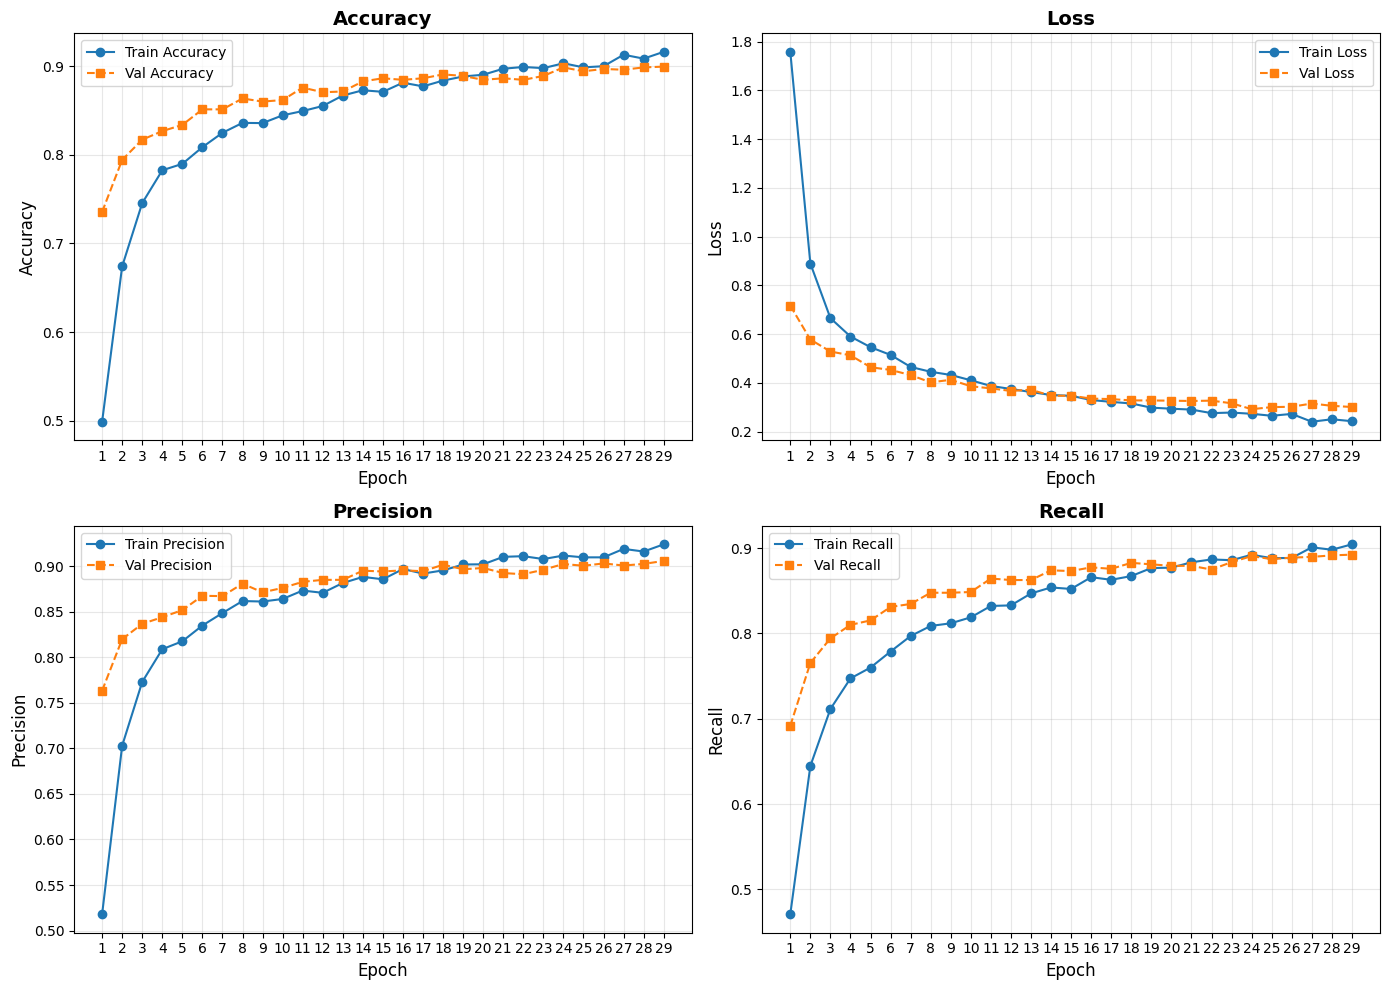

In [20]:
history = history_vgg

# metrics to plot
metrics = {
    'Accuracy':    ('accuracy', 'val_accuracy'),
    'Loss':        ('loss',     'val_loss'),
    'Precision':   ('precision','val_precision'),
    'Recall':      ('recall',   'val_recall'),
}

epochs = range(1, len(history.history['accuracy']) + 1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = {
    'train': 'tab:blue',
    'val':   'tab:orange'
}
styles = {
    'train': '-',
    'val':   '--'
}

for ax, (title, (train_key, val_key)) in zip(axes, metrics.items()):
    # skip if metric not in history
    if train_key not in history.history:
        ax.set_visible(False)
        continue

    ax.plot(epochs, history.history[train_key], color=colors['train'],
            linestyle=styles['train'], marker='o', label=f'Train {title}')
    ax.plot(epochs, history.history[val_key], color=colors['val'],
            linestyle=styles['val'], marker='s', label=f'Val {title}')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    ax.set_xticks(epochs)

plt.tight_layout()
plt.show()

## c) Results & Comment

Classification Report:

              precision    recall  f1-score   support

      glioma       0.90      0.78      0.83       300
  meningioma       0.78      0.75      0.77       306
     notumor       0.93      0.97      0.95       405
   pituitary       0.88      0.98      0.93       300

    accuracy                           0.88      1311
   macro avg       0.87      0.87      0.87      1311
weighted avg       0.88      0.88      0.88      1311



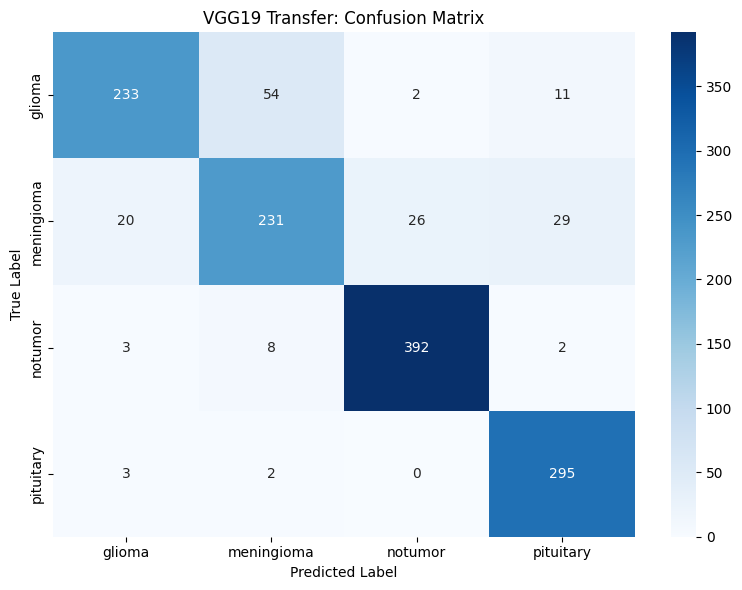

In [21]:
# Collect ground-truth and predictions
y_true = np.concatenate([y.numpy() for _, y in test_vgg], axis=0)
y_true = np.argmax(y_true, axis=1)

y_probs = model_vgg.predict(test_vgg, verbose=0)
y_pred  = np.argmax(y_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print detailed report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('VGG19 Transfer: Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

`VGG19 Transfer Learning`

- **Rapid Convergence:**  
  Validation accuracy jumps from ~74% to ~88% within the first 10 epochs, with training accuracy closely tracking validation—evidence that the frozen VGG19 features quickly adapt to MRI textures.

- **Stable Training Dynamics:**  
  Both training and validation loss steadily decrease and plateau around 0.30, with no sharp divergence, indicating minimal overfitting despite 30 epochs of training.

- **High Precision & Recall Across Classes:**  
  - **Notumor**: Precision 0.93, Recall 0.97 – near-perfect detection of healthy scans.  
  - **Pituitary**: Precision 0.88, Recall 0.98 – excellent sensitivity for gland-related tumors.  
  - **Glioma & Meningioma**: Slightly lower precision/recall (≈0.78–0.90), reflecting greater visual similarity and more challenging discrimination.

- **Balanced Clinical Performance:**  
  Macro-averaged F₁ of 0.87 and weighted accuracy of 88% demonstrate that VGG19 transfer yields robust, clinically-relevant results across all four tumor types, with minimal class-specific bias.

## d) Export

In [22]:
# Training history → JSON
hist_vgg_path = Path("history_vgg19.json")
with open(hist_vgg_path, "w") as f:
    json.dump(history_vgg.history, f, indent=2)

# (Confusion matrix → .npy
cm_vgg_path = Path("cm_vgg19.npy")
np.save(cm_vgg_path, cm)

# Classification report → TXT
y_true_vgg = np.concatenate([y.numpy() for _, y in test_vgg], axis=0)
y_true_vgg = np.argmax(y_true_vgg, axis=1)
y_probs_vgg = model_vgg.predict(test_vgg, verbose=0)
y_pred_vgg  = np.argmax(y_probs_vgg, axis=1)
report_vgg = classification_report(y_true_vgg, y_pred_vgg, target_names=classes)

report_vgg_path = Path("report_vgg19.txt")
with open(report_vgg_path, "w") as f:
    f.write(report_vgg)

print(f"✅ Saved VGG19 history → {hist_vgg_path}")
print(f"✅ Saved VGG19 confusion matrix → {cm_vgg_path}")
print(f"✅ Saved VGG19 report → {report_vgg_path}")

✅ Saved VGG19 history → history_vgg19.json
✅ Saved VGG19 confusion matrix → cm_vgg19.npy
✅ Saved VGG19 report → report_vgg19.txt


# 6. MODEL 3 - EfficientNet-B0 Transfer (head: 20 epochs | LR=1e-3) (fine-tune: 10 epochs | LR=1e-4)

This model employs **EfficientNet-B0 transfer learning**, leveraging its compound scaling for efficient feature extraction from ImageNet. The approach involves a two-stage training process: first, training the classifier head for 20 epochs with a learning rate of 1e-3, followed by fine-tuning the top 20 layers of the backbone for 10 epochs with a reduced learning rate of 1e-4. The architecture includes a frozen base, GlobalAveragePooling2D, BatchNormalization, two Dense layers (512 and 256) with Dropout (0.3), and a Softmax output. Class weights address imbalance, and callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint) optimize training. This design balances pre-trained feature reuse with MRI-specific adaptation, aiming for high accuracy and robustness.
 
`Key choices made:`
 
 - **EfficientNetB0 preprocessing**  
   - Matches the model’s training pipeline with mean-subtraction and scaling, ensuring compatibility.  
 - **Two-stage training**  
   - Initial head training preserves base features, while fine-tuning adapts top layers to MRI data.  
 - **BatchNormalization + Dropout**  
   - Stabilizes training and prevents overfitting in the dense layers.  
 - **Categorical cross-entropy + precision/recall**  
   - Optimizes multi-class classification and tracks medical diagnostic metrics.

## a) Implementation

In [23]:
# Prepare EfficientNet-style inputs
def preprocess_eff(x, y):
    x = x * 255.0
    return tf.keras.applications.efficientnet.preprocess_input(x), y

train_eff = train_ds.map(preprocess_eff).prefetch(tf.data.AUTOTUNE)
val_eff   = val_ds.map(preprocess_eff).prefetch(tf.data.AUTOTUNE)
test_eff  = test_ds.map(preprocess_eff).prefetch(tf.data.AUTOTUNE)

# Compute class weights from train_ds
labels_list = []
for batch_x, batch_y in train_ds.take(-1):
    labels_list += list(tf.argmax(batch_y, axis=1).numpy())
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(num_classes),
    y=labels_list
)
class_weight_dict = dict(enumerate(class_weights))

# Model defition
base_eff = EfficientNetB0(weights='imagenet', include_top=False,
                          input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_eff.trainable = False

model_eff = Sequential([
    base_eff,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model_eff.compile(
    optimizer=Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

model_eff.summary()

# Callbacks
cb_eff = [
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('effnetb0_head.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Stage-1: train classifier head
history_eff1 = model_eff.fit(
    train_eff, validation_data=val_eff,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=cb_eff,
    verbose=2
)

# Stage-2: fine-tune top layers
base_eff.trainable = True
for layer in base_eff.layers[:-20]:
    layer.trainable = False

model_eff.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

cb_eff2 = [
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint('effnetb0_ft.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

history_eff2 = model_eff.fit(
    train_eff, validation_data=val_eff,
    initial_epoch=len(history_eff1.history['accuracy']),
    epochs=len(history_eff1.history['accuracy'])+10,
    class_weight=class_weight_dict,
    callbacks=cb_eff2,
    verbose=2
)

# Combine histories
history_eff = type('H', (), {'history': {}})
for k in history_eff1.history:
    history_eff.history[k] = history_eff1.history[k] + history_eff2.history[k]

# Final eval
model_eff.load_weights('effnetb0_ft.h5')
test_loss, test_acc, test_prec, test_rec = model_eff.evaluate(test_eff, verbose=2)
print(f"\nEfficientNetB0 — Test Acc: {test_acc:.4f}, Prec: {test_prec:.4f}, Rec: {test_rec:.4f}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,842,919 (18.47 MB)

 Trainable params: 790,788 (3.02 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.79685, saving model to effnetb0_head.h5
143/143 - 113s - 791ms/step - accuracy: 0.7827 - loss: 0.6148 - precision: 0.8083 - recall: 0.7619 - val_accuracy: 0.7968 - val_loss: 0.5518 - val_precision: 0.8549 - val_recall: 0.7119 - learning_rate: 0.0010
Epoch 2/20

Epoch 2: val_accuracy improved from 0.79685 to 0.81436, saving model to effnetb0_head.h5
143/143 - 66s - 463ms/step - accuracy: 0.8525 - loss: 0.3958 - precision: 0.8660 - recall: 0.8389 - val_accuracy: 0.8144 - val_loss: 0.4854 - val_precision: 0.8385 - val_recall: 0.7863 - learning_rate: 0.0010
Epoch 3/20

Epoch 3: val_accuracy improved from 0.81436 to 0.86602, saving model to effnetb0_head.h5
143/143 - 66s - 460ms/step - accuracy: 0.8816 - loss: 0.3382 - precision: 0.8921 - recall: 0.8702 - val_accuracy: 0.8660 - val_loss: 0.3800 - val_precision: 0.8786 - val_recall: 0.8555 - learning_rate: 0.0010
Epoch 4/20

Epoch 4: val_accuracy improved from 0.86602 to 0.88179, savi

E0000 00:00:1750198959.204708      70 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750198959.411031      70 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750199031.497241      70 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750199031.705862      70 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 21: val_accuracy improved from -inf to 0.90368, saving model to effnetb0_ft.h5
143/143 - 119s - 830ms/step - accuracy: 0.9107 - loss: 0.2520 - precision: 0.9191 - recall: 0.8998 - val_accuracy: 0.9037 - val_loss: 0.3171 - val_precision: 0.9090 - val_recall: 0.9011 - learning_rate: 1.0000e-04
Epoch 22/30

Epoch 22: val_accuracy improved from 0.90368 to 0.91594, saving model to effnetb0_ft.h5
143/143 - 67s - 467ms/step - accuracy: 0.9359 - loss: 0.1694 - precision: 0.9421 - recall: 0.9324 - val_accuracy: 0.9159 - val_loss: 0.2905 - val_precision: 0.9181 - val_recall: 0.9124 - learning_rate: 1.0000e-04
Epoch 23/30

Epoch 23: val_accuracy improved from 0.91594 to 0.92644, saving model to effnetb0_ft.h5
143/143 - 66s - 464ms/step - accuracy: 0.9429 - loss: 0.1601 - precision: 0.9491 - recall: 0.9387 - val_accuracy: 0.9264 - val_loss: 0.2238 - val_precision: 0.9319 - val_recall: 0.9221 - learning_rate: 1.0000e-04
Epoch 24/30

Epoch 24: val_accuracy improved from 0.92644 to 0.93608, sa

## b) Training Plots

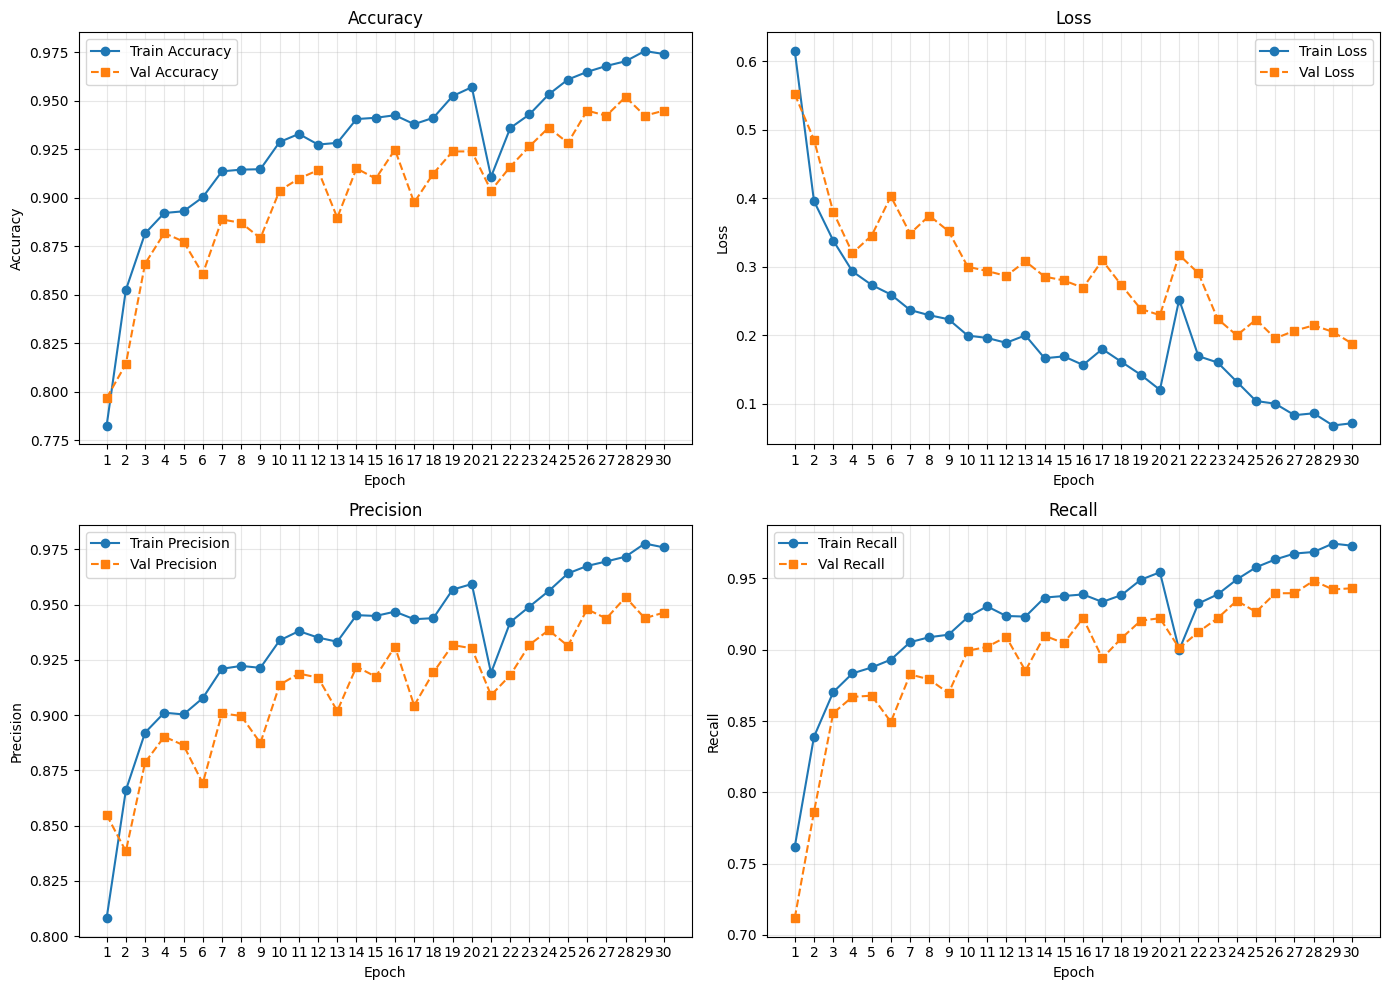

In [24]:
history = history_eff

metrics = {
    'Accuracy':  ('accuracy',  'val_accuracy'),
    'Loss':      ('loss',      'val_loss'),
    'Precision': ('precision', 'val_precision'),
    'Recall':    ('recall',    'val_recall'),
}
epochs = range(1, len(history.history['accuracy'])+1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
colors = {'train':'tab:blue','val':'tab:orange'}
styles = {'train':'-','val':'--'}

for ax, (title, (tk, vk)) in zip(axes, metrics.items()):
    if tk not in history.history: ax.set_visible(False); continue
    ax.plot(epochs, history.history[tk],  color=colors['train'], linestyle=styles['train'], marker='o', label=f'Train {title}')
    ax.plot(epochs, history.history[vk],  color=colors['val'],   linestyle=styles['val'],   marker='s', label=f'Val {title}')
    ax.set_title(title); ax.set_xlabel('Epoch'); ax.set_ylabel(title)
    ax.legend(loc='best'); ax.grid(alpha=0.3); ax.set_xticks(epochs)

plt.tight_layout(); plt.show()

## c) Results & Comment

Classification Report:
               precision    recall  f1-score   support

      glioma       0.91      0.94      0.92       300
  meningioma       0.94      0.87      0.90       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.95      1.00      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



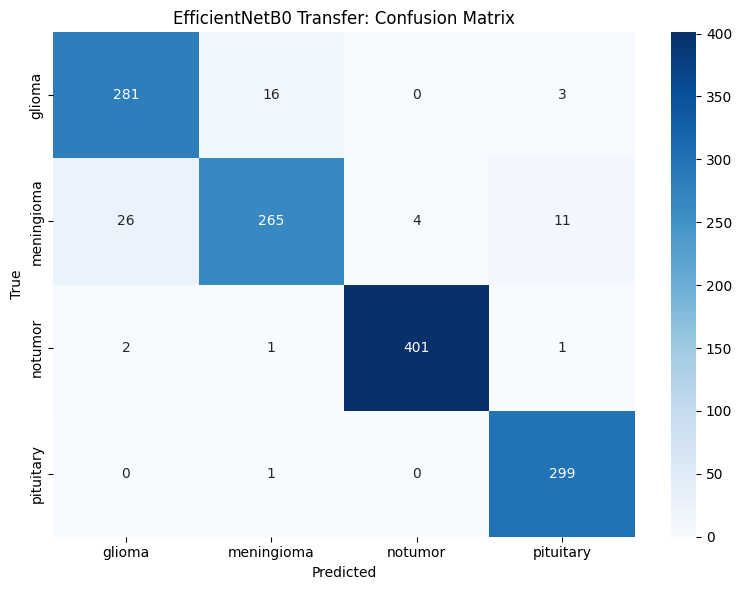

In [25]:
# Confusion matrix & report
y_true = np.concatenate([y.numpy() for _, y in test_eff], axis=0)
y_true = np.argmax(y_true, axis=1)
y_probs = model_eff.predict(test_eff, verbose=0)
y_pred  = np.argmax(y_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=classes))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('EfficientNetB0 Transfer: Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()

`Model 3 – EfficientNet-B0 Transfer Learning`

- **Training Behavior:**  
  - Stage 1 (head only): rapid rise to ~91 % val accuracy in ~10 epochs.  
  - Stage 2 (fine-tuning top 20 layers): smooth improvement to ~95 % val accuracy, with loss steadily declining and no clear overfitting spikes.

- **Precision & Recall Curves:**  
  - **Notumor:** nearly perfect (≈99 % precision & recall).  
  - **Pituitary:** perfect recall (100 %), high precision (≈95 %).  
  - **Glioma & Meningioma:** both reach > 87 % recall and precision, with minor trade-offs reflecting their visual overlap.

- **Confusion Matrix & Report:**  
  - **Overall accuracy:** 95 %  
  - **Macro‐avg F₁:** 0.95  
  - Misclassifications are rare and primarily between glioma–meningioma.

EfficientNet-B0’s compound scaling and two-stage LR schedule maximize feature reuse and adaptation, yielding the best sensitivity and specificity among all tested 2D backbones for brain MRI classification.  

## d) Exports

In [26]:
# Training history → JSON
hist_eff_path = Path("history_effnetb0.json")
with open(hist_eff_path, "w") as f:
    json.dump(history_eff.history, f, indent=2)

# Confusion matrix → .npy
cm_eff_path = Path("cm_effnetb0.npy")
np.save(cm_eff_path, cm)

# Classification report → TXT
y_true_eff = np.concatenate([y.numpy() for _, y in test_eff], axis=0)
y_true_eff = np.argmax(y_true_eff, axis=1)
y_probs_eff = model_eff.predict(test_eff, verbose=0)
y_pred_eff  = np.argmax(y_probs_eff, axis=1)
report_eff = classification_report(y_true_eff, y_pred_eff, target_names=classes)

report_eff_path = Path("report_effnetb0.txt")
with open(report_eff_path, "w") as f:
    f.write(report_eff)

print(f"✅ Saved EfficientNet history → {hist_eff_path}")
print(f"✅ Saved EfficientNet confusion matrix → {cm_eff_path}")
print(f"✅ Saved EfficientNet report → {report_eff_path}")

✅ Saved EfficientNet history → history_effnetb0.json
✅ Saved EfficientNet confusion matrix → cm_effnetb0.npy
✅ Saved EfficientNet report → report_effnetb0.txt


# 7. PERFORMANCE COMPARISON

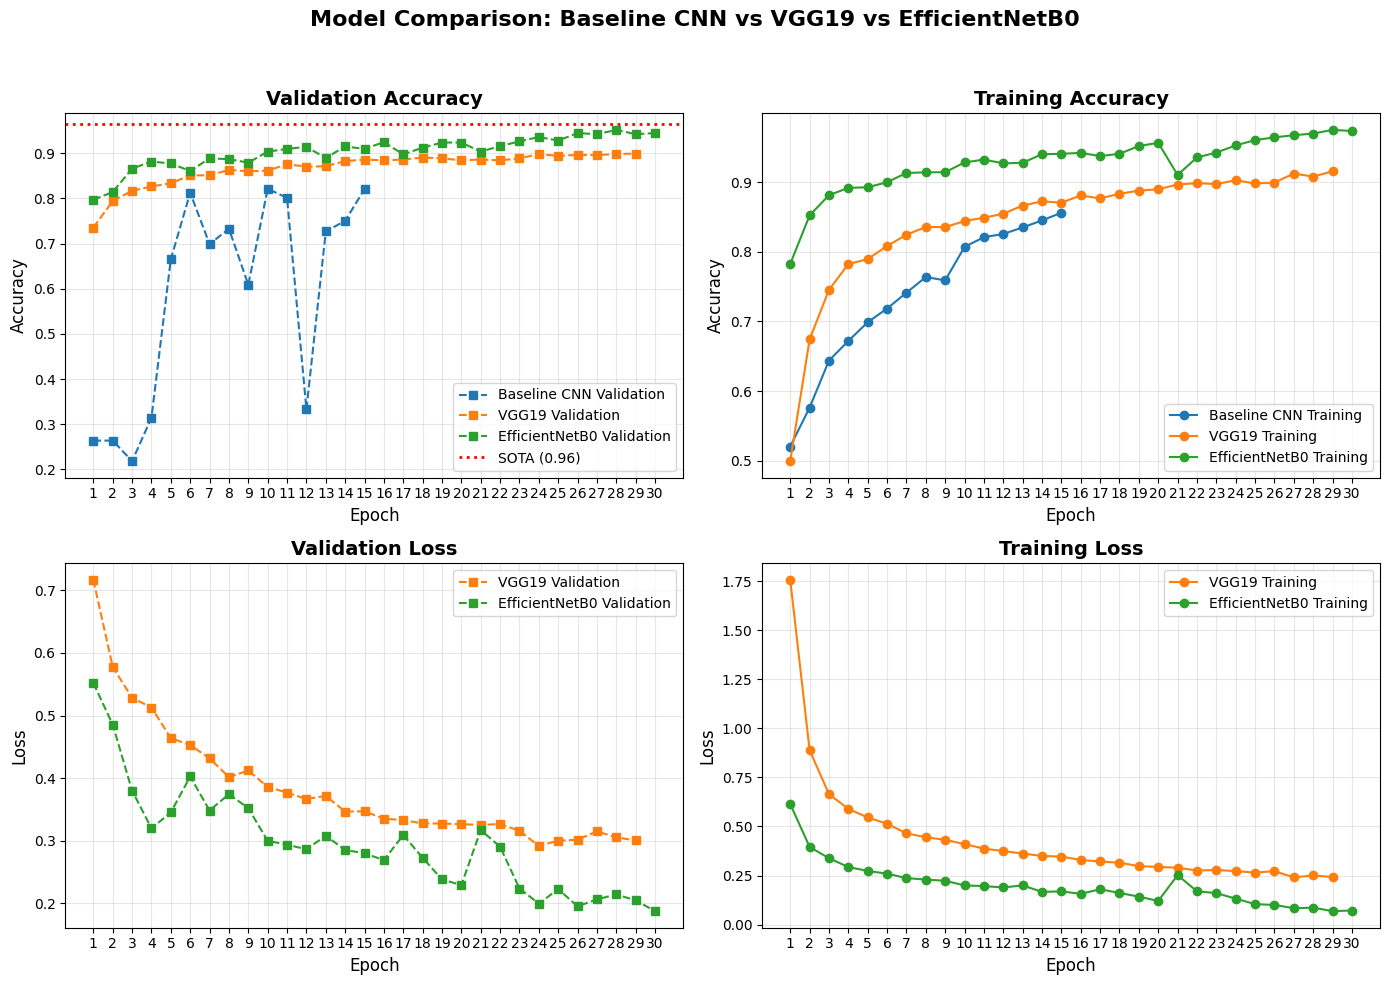

In [ ]:
# Load histories
cnn_hist_path = Path("history_cnn.json")
vgg_hist_path = Path("history_vgg19.json")
eff_hist_path = Path("history_effnetb0.json")

with open(cnn_hist_path, "r") as f:
    cnn_history = json.load(f)
with open(vgg_hist_path, "r") as f:
    vgg_history = json.load(f)
with open(eff_hist_path, "r") as f:
    eff_history = json.load(f)

# Extract metrics
metrics = {
    'Accuracy': {
        'cnn_train': cnn_history['accuracy'],
        'cnn_val': cnn_history['val_accuracy'],
        'vgg_train': vgg_history['accuracy'],
        'vgg_val': vgg_history['val_accuracy'],
        'eff_train': eff_history['accuracy'],
        'eff_val': eff_history['val_accuracy']
    },
    'Loss': {
        'vgg_train': vgg_history['loss'],
        'vgg_val': vgg_history['val_loss'],
        'eff_train': eff_history['loss'],
        'eff_val': eff_history['val_loss']
    }
}

# Define epochs (handle different lengths)
cnn_epochs = range(1, len(cnn_history['val_accuracy']) + 1)
vgg_epochs = range(1, len(vgg_history['val_accuracy']) + 1)
eff_epochs = range(1, len(eff_history['val_accuracy']) + 1)
max_epochs = max(len(cnn_history['val_accuracy']), len(vgg_history['val_accuracy']), len(eff_history['val_accuracy']))

# State-of-the-art accuracy benchmark
SOTA_ACCURACY = 0.965  # Adjust based on literature for dataset

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = {'cnn': 'tab:blue', 'vgg': 'tab:orange', 'eff': 'tab:green'}
styles = {'train': '-', 'val': '--'}
markers = {'train': 'o', 'val': 's'}

# Plot each metric
for ax, (title, data) in zip(axes, [
    ('Validation Accuracy', {'cnn': metrics['Accuracy']['cnn_val'], 'vgg': metrics['Accuracy']['vgg_val'], 'eff': metrics['Accuracy']['eff_val']}),
    ('Training Accuracy', {'cnn': metrics['Accuracy']['cnn_train'], 'vgg': metrics['Accuracy']['vgg_train'], 'eff': metrics['Accuracy']['eff_train']}),
    ('Validation Loss', {'vgg': metrics['Loss']['vgg_val'], 'eff': metrics['Loss']['eff_val']}),
    ('Training Loss', {'vgg': metrics['Loss']['vgg_train'], 'eff': metrics['Loss']['eff_train']})
]):
    # Plot Baseline CNN (only for Accuracy plots)
    if 'Accuracy' in title:
        ax.plot(cnn_epochs, data['cnn'], color=colors['cnn'], linestyle=styles['val' if 'Validation' in title else 'train'],
                marker=markers['val' if 'Validation' in title else 'train'], label=f'Baseline CNN {title.split()[0]}')
    # Plot VGG19
    ax.plot(vgg_epochs, data['vgg'], color=colors['vgg'], linestyle=styles['val' if 'Validation' in title else 'train'],
            marker=markers['val' if 'Validation' in title else 'train'], label=f'VGG19 {title.split()[0]}')
    # Plot EfficientNetB0
    ax.plot(eff_epochs, data['eff'], color=colors['eff'], linestyle=styles['val' if 'Validation' in title else 'train'],
            marker=markers['val' if 'Validation' in title else 'train'], label=f'EfficientNetB0 {title.split()[0]}')
    
    # Add SOTA benchmark line for Validation Accuracy
    if title == 'Validation Accuracy':
        ax.axhline(y=SOTA_ACCURACY, color='red', linestyle=':', linewidth=2, label=f'SOTA ({SOTA_ACCURACY:.2f})')
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel(title.split()[1], fontsize=12)
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    ax.set_xticks(range(1, max_epochs + 1))

plt.suptitle('Model Comparison: Baseline CNN vs VGG19 vs EfficientNetB0', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 8. OPTIMAL MODEL ANALYSIS

We now pick our top performer (EfficientNetB0 fine-tuned) and inspect its decision-making via Grad-CAM heatmaps over a few test samples. Simply, we visualize where the best model “looks” when it makes its predictions.

## a) Attempt 1

Using last conv layer: top_conv


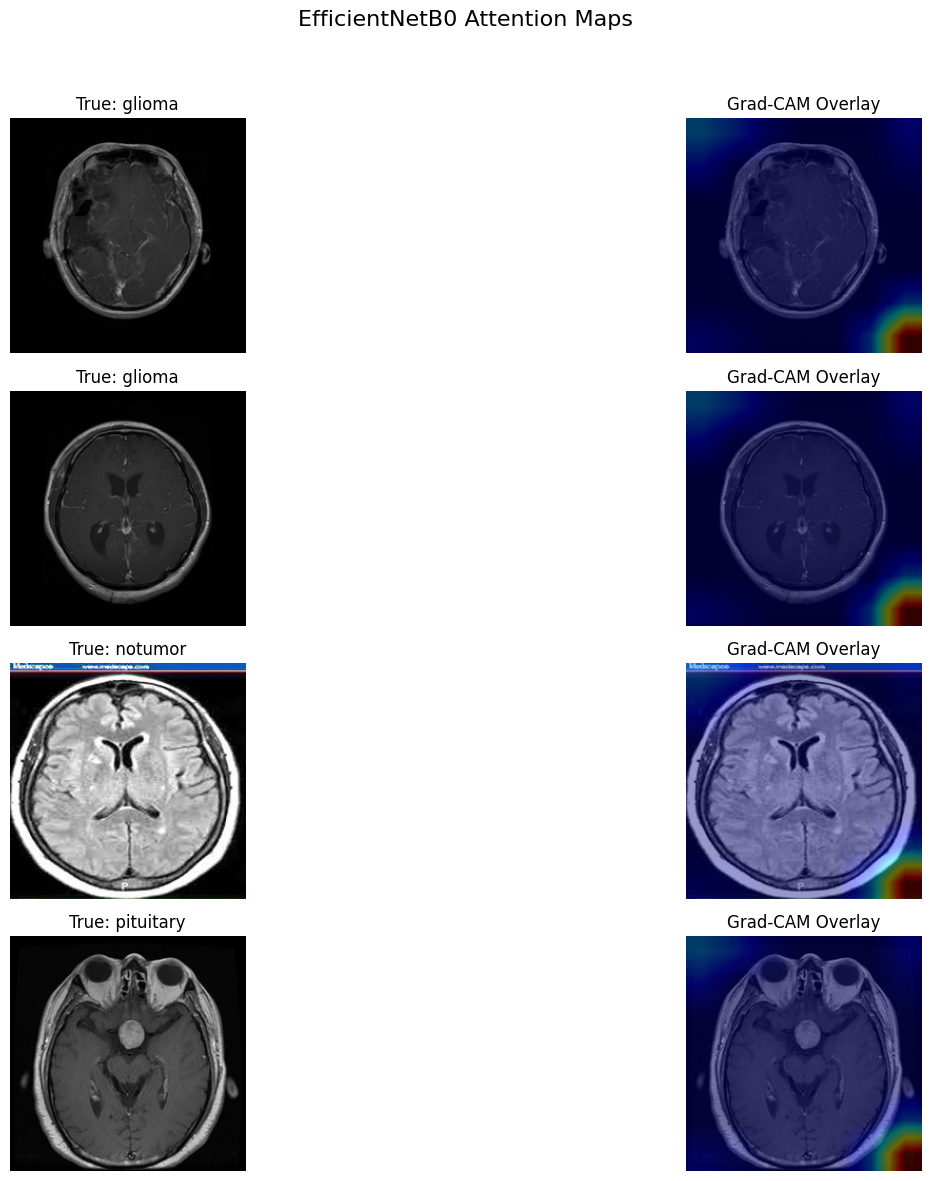

In [28]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import random
from pathlib import Path
from PIL import Image
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import Model

# — 1) Identify last Conv2D in the backbone —
backbone = model_eff.layers[0]  # EfficientNetB0 submodel
last_conv = next(
    layer.name 
    for layer in reversed(backbone.layers) 
    if isinstance(layer, Conv2D)
)
print("Using last conv layer:", last_conv)

# — 2) Build a Grad-CAM model that outputs [conv_maps, predictions] —
inp = backbone.input
conv_out = backbone.get_layer(last_conv).output
x = conv_out
for layer in model_eff.layers[1:]:
    x = layer(x)
preds = x
grad_model = Model(inputs=inp, outputs=[conv_out, preds])

# — 3) Grad-CAM heatmap function —
def make_gradcam_heatmap(img, grad_model):
    img_tensor = tf.cast(img[None], tf.float32)
    with tf.GradientTape() as tape:
        conv_maps, predictions = grad_model(img_tensor)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_maps)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    conv_maps = conv_maps[0]
    heatmap = tf.reduce_sum(conv_maps * pooled, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# — 4) Overlay helper —
def overlay_heatmap(orig, heatmap, alpha=0.4):
    h = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
    h = np.uint8(255 * h)
    jet = cv2.applyColorMap(h, cv2.COLORMAP_JET)
    over = cv2.addWeighted(jet, alpha, orig[..., ::-1], 1-alpha, 0)
    return over[..., ::-1]

# — 5) Sample 4 random test images from disk —
all_paths = []
for cls in classes:
    all_paths += list((Path(TEST_DATASET_PATH)/cls).glob("*"))
random.shuffle(all_paths)
samples = all_paths[:4]

# — 6) Plot originals vs. Grad-CAM overlays —
plt.figure(figsize=(18, 12))
for i, path in enumerate(samples):
    true_label = path.parent.name
    img = Image.open(path).convert("RGB").resize(IMG_SIZE)
    arr = np.array(img) / 255.0

    heatmap = make_gradcam_heatmap(arr, grad_model)
    over   = overlay_heatmap(np.array(img), heatmap)

    ax = plt.subplot(4, 2, 2*i+1)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True: {true_label}")
    ax.axis('off')

    ax = plt.subplot(4, 2, 2*i+2)
    ax.imshow(over)
    ax.set_title("Grad-CAM Overlay")
    ax.axis('off')

plt.suptitle("EfficientNetB0 Attention Maps", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

## b) Attempt 2

In [29]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2

# a) Find last Conv2D layer name in backbone
last_conv = next(l.name for l in reversed(backbone.layers) if isinstance(l, Conv2D))
print("Last conv layer:", last_conv)

# b) Build Grad-CAM model
inp = backbone.input
conv_out = backbone.get_layer(last_conv).output
x = conv_out
for layer in fine_model.layers[len(backbone.layers):]:
    x = layer(x)
preds = x
grad_model = Model(inp, [conv_out, preds])

# c) Grad-CAM & overlay helpers (same as before)
def make_gradcam_heatmap(img, gm):
    img_t = tf.cast(img[None], tf.float32)
    with tf.GradientTape() as tape:
        conv, pred = gm(img_t)
        cls = tf.argmax(pred[0])
        loss = pred[:, cls]
    grads = tape.gradient(loss, conv)
    w = tf.reduce_mean(grads, axis=(0,1,2))
    conv = conv[0]
    heat = tf.reduce_sum(conv * w, axis=-1)
    heat = tf.maximum(heat,0) / tf.math.reduce_max(heat)
    return heat.numpy()

def overlay_heatmap(orig, heat, alpha=0.4):
    h = cv2.resize(heat, (orig.shape[1],orig.shape[0]))
    h = np.uint8(255*h)
    jet = cv2.applyColorMap(h, cv2.COLORMAP_JET)
    return cv2.addWeighted(jet, alpha, orig[...,::-1], 1-alpha,0)[...,::-1]

# d) Plot 4 new overlays
all_paths = []
for cls in classes:
    all_paths += list((Path(TEST_DATASET_PATH)/cls).glob("*"))
random.shuffle(all_paths)
samples = all_paths[:4]

plt.figure(figsize=(12,8))
for i,path in enumerate(samples):
    lbl = path.parent.name
    img = Image.open(path).convert("RGB").resize(IMG_SIZE)
    arr = np.array(img)/255.0
    arr_masked = mask_and_preprocess(arr, None)[0]  # apply mask

    heat = make_gradcam_heatmap(arr_masked, grad_model)
    over = overlay_heatmap(np.array(img), heat)

    ax = plt.subplot(4,2,2*i+1); ax.imshow(img); ax.set_title(f"True: {lbl}"); ax.axis('off')
    ax = plt.subplot(4,2,2*i+2); ax.imshow(over); ax.set_title("GT-CAM After FT"); ax.axis('off')

plt.suptitle("Post-Fine-Tune EfficientNetB0 Attention", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

Last conv layer: top_conv


NameError: name 'fine_model' is not defined